In [1]:
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as datetime
import operator
import scipy.spatial.distance as distance
from sklearn import metrics 
import random
import pickle
import time
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
import fastparquet
from scipy.sparse import csr_matrix
from surprise import SVD,Dataset,Reader 
from surprise.model_selection import cross_validate
from surprise import SVDpp, SlopeOne, NMF, NormalPredictor, KNNBaseline, KNNBasic, KNNWithMeans, KNNWithZScore, BaselineOnly, CoClustering

# so far

- Using rating sample, in future we can run for complete user_ratings 

- comparison between all the surprise models using cv = 5, stored comparison in test_rmse_score_comparison

- selected the model with the least test_rmse

- recommend ratings to the user

# Next:

- convert the model prediction into a function

- a separate file for model retrain

- requires minimum 20 ratings from the user to retrain model

- run evaluations 

# Reading all the files

Execute the recommendation exploration with subsample 50% and rename the following files to 

- processed_df -> processed_df_collab

- ratings_sample -> ratings_sample_collab

- movies_ratings -> movies_ratings_collab

In [6]:
df = pd.read_parquet('processed_df_collab.parq')
ratings = pd.read_parquet('ratings_sample_collab.parq')
ratings = ratings.reset_index()
movies_raitings = pd.read_parquet('movies_ratings_collab.parq')
movies_raitings = movies_raitings.rename(columns={"avg": "Average_Ratings"})

# Filtering movies rated at most by 50 users

In [7]:
df_titles = df[['movieId','title_eng']]

In [8]:
filtered_movies = movies_raitings[movies_raitings['cnt']>50].movieId.values

In [9]:
movie_rating = ratings[ratings.movieId.isin(filtered_movies)]

# Keeping the users who have rated minimum of 20 movies

In [10]:
user_list = ratings.groupby('userId')['userId'].count().reset_index(name="rating_count")
users_list = set(user_list[user_list['rating_count']>=20]['userId'].values)
print(f' Number of users who rated at least 20 movies: {len(users_list)}')

 Number of users who rated at least 20 movies: 115856


# Comparing models using 2000 users data

In [11]:
random.seed(42)
n_users = 2000
random_users = random.sample(users_list, n_users)
users_ratings = movie_rating[movie_rating.userId.isin(random_users)]
len(users_ratings)

195517

In [12]:
users_ratings = users_ratings[['userId','movieId','rating']]

# getting the min max rating 

In [215]:
min_rat = users_ratings.rating.min()

In [216]:
max_rat = users_ratings.rating.max()

# specify the range of rating

In [217]:
reader = Reader(rating_scale=(min_rat,max_rat))

# Loading users_ratings using load_from_df for model comparison: 
The columns must correspond to user id, item id and ratings (in that order)

In [218]:
data = Dataset.load_from_df(users_ratings, reader)

# Comparing models using:

- Filtering movies that are atleast rated by 50 users

- Filtering users have atleast rated 20 movies

- Taking only 2000 users data 


## Models compared - SVD()

- SVD()

- SVDpp()

- SlopeOne() 

- NMF()

- NormalPredictor()

- KNNBaseline()

- KNNBasic()

- KNNWithMeans()

- KNNWithZScore()

- BaselineOnly()

- CoClustering()

The below block has been executed once, I have commented it now. The results are stored and can be read from the parq file.

In [36]:
"""
results_test_df = []
# Iterate over all surprise algorithms

for algorithm in [SVD(), SVDpp(), SlopeOne(), NMF(), NormalPredictor(), KNNBaseline(), KNNBasic(), KNNWithMeans(), KNNWithZScore(), BaselineOnly(), CoClustering()]:
    # Perform cross validation cv =5
    results = cross_validate(algorithm, data, measures=['RMSE'], cv=5, verbose=False)
    
    # Get results & append into results_test_df
    tmp = pd.DataFrame.from_dict(results).mean(axis=0)
    tmp = tmp.append(pd.Series([str(algorithm).split(' ')[0].split('.')[-1]], index=['Algorithm']))
    results_test_df.append(tmp)
    
pd.DataFrame(results_test_df).set_index('Algorithm').sort_values('test_rmse')  

"""



Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Don

,test_rmse,fit_time,test_time
Algorithm,,,
SVDpp,0.870838,750.548304,8.109057
KNNBaseline,0.878081,2.111808,11.520009
BaselineOnly,0.878819,0.696858,0.565961
SVD,0.884845,6.801081,0.555114
KNNWithZScore,0.893763,1.255122,7.649508
KNNWithMeans,0.895202,1.205560,8.984960
SlopeOne,0.895398,247.660159,18.841247
NMF,0.920075,27.935698,1.137187
CoClustering,0.939221,4.204486,0.627891


# df_test_score contains the comparison statistics of the above models 

In [37]:
# df_test_score = pd.DataFrame(results_test_df).set_index('Algorithm').sort_values('test_rmse')  

# Storing the comparison results

In [38]:
# df_test_score.to_parquet('test_rmse_score_comparison.parq', engine = 'fastparquet', compression = 'GZIP')

# getting the model with least rmse

In [39]:
df_test_score = pd.read_parquet('test_rmse_score_comparison.parq')

df_test_score[:1]

,test_rmse,fit_time,test_time
Algorithm,,,
SVDpp,0.870838,750.548304,8.109057


# Building a recommendation model using SVDpp()

The model has beed commented and dumped into a pickle file.

In [40]:
#svd = SVDpp()

## Building a train set using the complete data

In [219]:
#trainset = data.build_full_trainset()

## fit the trainset

In [43]:
#svd.fit(trainset)

## save the model 

In [44]:
#filename = 'svdpp_model.pkl'
#pickle.dump(svd, open(filename, 'wb'))

In [ ]:
## load the model from the dump

In [46]:
svdpp = pickle.load(open(filename, 'rb'))

## Recommendation:


1) testset : Create user Item combination that is not available in the train set.

2) predictions: predict ratings for the user-item in the test set

3) Save all the predictions data into predicted_ratings

All the predictions are saved into the predictions_df



In [47]:
#testset = trainset.build_anti_testset()

In [48]:
#predictions = svdpp.test(testset)

In [49]:
#predicted_ratings = pd.DataFrame(predictions)


In [53]:
#predicted_ratings.to_parquet('predictions_df.parq', compression='gzip')

In [13]:
predicted_ratings = pd.read_parquet('predictions_df.parq')

In [14]:
predicted_ratings

,uid,iid,r_ui,est,details
0,17218,103772,3.542758,2.757767,{'was_impossible': False}
1,17218,4563,3.542758,2.273232,{'was_impossible': False}
2,17218,34528,3.542758,3.309192,{'was_impossible': False}
3,17218,1833,3.542758,2.895534,{'was_impossible': False}
4,17218,5574,3.542758,2.818893,{'was_impossible': False}
...,...,...,...,...,...
17078478,137892,132798,3.542758,3.791802,{'was_impossible': False}
17078479,137892,8484,3.542758,3.955393,{'was_impossible': False}
17078480,137892,180987,3.542758,3.665819,{'was_impossible': False}
17078481,137892,3473,3.542758,3.736806,{'was_impossible': False}


In [15]:
def collaborative_filtering_model(userId,movie_ratings,predicted_ratings,top_n):
    
    """
    This functions recommends top_n movies to the end user
    
    """

    single_user = predicted_ratings[predicted_ratings['uid']==userId]
    top_nmovies = single_user.sort_values(by = ['est'] , ascending = False)[:top_n]['iid']
    
    recommendations = pd.merge(top_nmovies,movies_raitings, how='left', left_on='iid',right_on='movieId')
    
    
    recommendations = recommendations[['movieId', 'title_eng', 'Average_Ratings', 'cnt']]
    
    return recommendations

In [16]:
userIds= set(np.unique(users_ratings.userId.values))

In [17]:
user_id =random.sample(userIds,1)
user_id =user_id[0]
top_n = 10

In [18]:
user_id

148628

In [19]:
user_recommendation = collaborative_filtering_model(user_id,movies_raitings,predicted_ratings,top_n)

In [20]:
user_recommendation

,movieId,title_eng,Average_Ratings,cnt
0,5008,Witness for the Prosecution (1957),4.049461,1021
1,1212,"Third Man, The (1949)",4.206949,3583
2,8516,"Matter of Life and Death, A (Stairway to Heave...",3.985437,206
3,2360,"Celebration, The (Festen) (1998)",4.100000,1230
4,57504,"Girl Who Leapt Through Time, The (Toki o kaker...",3.952910,945
5,318,"Shawshank Redemption, The (1994)",4.413564,40550
6,44555,"Lives of Others, The (Das leben der Anderen) (...",4.202884,4611
7,1949,"Man for All Seasons, A (1966)",4.110096,1040
8,2959,Fight Club (1999),4.230584,29408
9,55442,Persepolis (2007),3.929167,1680


In [21]:
user_recommendation

,movieId,title_eng,Average_Ratings,cnt
0,5008,Witness for the Prosecution (1957),4.049461,1021
1,1212,"Third Man, The (1949)",4.206949,3583
2,8516,"Matter of Life and Death, A (Stairway to Heave...",3.985437,206
3,2360,"Celebration, The (Festen) (1998)",4.100000,1230
4,57504,"Girl Who Leapt Through Time, The (Toki o kaker...",3.952910,945
5,318,"Shawshank Redemption, The (1994)",4.413564,40550
6,44555,"Lives of Others, The (Das leben der Anderen) (...",4.202884,4611
7,1949,"Man for All Seasons, A (1966)",4.110096,1040
8,2959,Fight Club (1999),4.230584,29408
9,55442,Persepolis (2007),3.929167,1680


In [24]:
recommendation_system = collaborative_filtering_model

In [ ]:
## Using the precision_recall_at_k from Surprise documentation : Need to do some changes before execution 

In [ ]:
def precision_recall_at_k(predictions, k=10, threshold=3.5):
    '''Return precision and recall at k metrics for each user.'''

    # First map the predictions to each user.
    user_est_true = defaultdict(list)
    for uid, _, true_r, est, _ in predictions:
        user_est_true[uid].append((est, true_r))

    precisions = dict()
    recalls = dict()
    for uid, user_ratings in user_est_true.items():

        # Sort user ratings by estimated value
        user_ratings.sort(key=lambda x: x[0], reverse=True)

        # Number of relevant items
        n_rel = sum((true_r >= threshold) for (_, true_r) in user_ratings)

        # Number of recommended items in top k
        n_rec_k = sum((est >= threshold) for (est, _) in user_ratings[:k])

        # Number of relevant and recommended items in top k
        n_rel_and_rec_k = sum(((true_r >= threshold) and (est >= threshold))
                              for (est, true_r) in user_ratings[:k])

        # Precision@K: Proportion of recommended items that are relevant
        precisions[uid] = n_rel_and_rec_k / n_rec_k if n_rec_k != 0 else 1

        # Recall@K: Proportion of relevant items that are recommended
        recalls[uid] = n_rel_and_rec_k / n_rel if n_rel != 0 else 1

    return precisions, recalls


data = data = Dataset.load_from_df(users_ratings, reader)

In [ ]:
kf = KFold(n_splits=5)
algo = SVD()

for trainset, testset in kf.split(data):
    algo.fit(trainset)
    predictions = algo.test(testset)
    precisions, recalls = precision_recall_at_k(predictions, k=5, threshold=4)

    # Precision and recall can then be averaged over all users
    print(sum(prec for prec in precisions.values()) / len(precisions))
    print(sum(rec for rec in recalls.values()) / len(recalls))

In [ ]:
f = open("collaborative_filtering_model_svdpp.txt", "w")

In [28]:
"""
get_users_prediction: returns user prediction

user_matrix: generated user by movies, 0: movie not recommended, 1: movie got recommended

"""
def get_users_prediction(users_list,top_n,users_prediction,recommendation_system,movies_raitings,predicted_ratings):
    for i in users_list:
        
        recommendation = recommendation_system(i,movies_raitings,predicted_ratings,top_n)
        
        prediction = recommendation['movieId'].astype(int).values
        users_prediction = users_prediction.append(pd.Series(prediction),ignore_index=True)
        
    return users_prediction

def user_matrix(users_pred):
    data_melt= pd.DataFrame(data=users_pred).reset_index().melt(id_vars='index', value_name='movieId',)
    data_melt = data_melt[['index', 'movieId']].pivot(index='index', columns='movieId', values='movieId')
    cols = data_melt.columns
    for i in cols:
        data_melt[i] = np.where(data_melt[i].isna(), 0, 1)
    return data_melt


def personalization(users_matrix,n):
    # generating cosine similarity between the users
    #then getting the indicies of elements above diagonal (giving diagonal offsert =1 in triu_indices)
    #calculating the avg of the element above diagonal 
    #Personalization means 1 - similarity
    #higher the personalization score, better the recommendation system in recommending personalized movies
   
    users_sim = metrics.pairwise.cosine_similarity(users_matrix)
    iu1 = np.triu_indices(n,k=1)
    similarity_avg = np.mean(users_sim[iu1])
    personalization_score = 1 - similarity_avg

    return personalization_score

def cross_fold_eval(unique_users,recommendation_system,movies_raitings,predicted_ratings,k_fold=10,n=10,top_n=10):
    #users_list: List of random n users
    
    kfold_personalization=0
    for i in range(k_fold):
        users_list = random.sample(unique_users,n)
        #columns: top_n recommendations
        #users_prediction:  top_n recommendations for n users
        column_names = list(range(top_n))
        users_prediction = pd.DataFrame(columns = column_names)
        
        # getting predictions for sampled users
        users_pred = get_users_prediction(users_list,top_n,users_prediction,recommendation_system, movies_raitings,predicted_ratings)
        
        # getting user by movies matrix with binary indicators 0: movie not recommended, 1: movie got recommended
        users_matrix = user_matrix(users_pred)
        kfold_personalization+=personalization(users_matrix,n)
    kfold_eval = kfold_personalization/k_fold
    print(f'Personalization score for {k_fold} folds across {n} users for top {top_n} recommendations: {round(kfold_eval,20)}')

In [29]:
"""
    unique_users: getting unique user set 
    
    default values given in function
    n: number of users 
    top_n: top number of recommendations (10)
    recommendation_system: Name of the recommendation system
    
"""

unique_users = set(users_ratings.userId)
start_time = time.time()
cross_fold_eval(unique_users,recommendation_system,movies_raitings,predicted_ratings, n = 20)

#end_time = time.time() - start_time
#print(f'Time take {end_time} seconds')

Personalization score for 10 folds across 20 users for top 10 recommendations: 0.8364736842105263


# Personal Diversity

In [165]:
def personal_diversity(top_n,n,list_user,movies_raitings,predicted_ratings,df,movieIds,cols):
    #random.seed(42)
    rand_user = random.sample(list_user, n)  
    length = len(rand_user)
    
    # storing diversity for n users
    diversity =[]
    for u in range(length):
        # getting recommended movies
        recommendation =  recommendation_system(rand_user[u],movies_raitings,predicted_ratings,top_n)
        prediction = recommendation['movieId'].astype(int).values
        predicted_index = [movieIds.index(i) for i in prediction]
        user_df = df.loc[predicted_index, :]
        user_movie_features = pd.DataFrame()
        
        # getting only the columns that have any value 1
        for k,i in enumerate(predicted_index):
            
            nonzero_cols = [cols[j] for j in user_df.loc[i,:].to_numpy().nonzero()[0]]
            
            d = {k:1 for k in nonzero_cols}
            d = pd.DataFrame(data = d, index = [prediction[k]])    
            user_movie_features = pd.concat([user_movie_features, d])
            

        # replace NaN with 0
        user_movie_features = user_movie_features.fillna(0)
        # generating cosine similarity between the users
        #then getting the indicies of elements above diagonal (giving diagonal offsert =1 in triu_indices)
        #calculating the avg of the element above diagonal 
        sim = metrics.pairwise.cosine_similarity(np.asmatrix(user_movie_features))

        iu1 = np.triu_indices(user_movie_features.shape[0],k=1)
        avg = 1 - np.mean(sim[iu1])
        
        print(f'Diversity of movies recommended for user {rand_user[u]}: {avg}')
        diversity.append(avg)
        
    # calculating avg diversity over n users
    avg_diversity = np.mean(diversity)
    print(avg_diversity)
    print(f'Average diversity over {n} users for their top {top_n} recommendations (0 = identical): {avg_diversity}')

In [174]:
"""
top_n: top n recommendations
n: number of users

Ignore warning for now - comming from recommendatiom function
Fixed the one from this function
"""

top_n = 10
n = 20
list_user = set(users_ratings.userId)

personal_diversity(top_n,n,list_user,movies_raitings,predicted_ratings,df,movieIds,cols)
# function call for personal diversity

Diversity of movies recommended for user 67346: 0.3493677711044981
Diversity of movies recommended for user 42881: 0.3651377250380803
Diversity of movies recommended for user 77854: 0.3427906595003888
Diversity of movies recommended for user 78664: 0.36756257682935933
Diversity of movies recommended for user 57621: 0.3710084360547097
Diversity of movies recommended for user 12833: 0.40666762596301753
Diversity of movies recommended for user 67181: 0.35554156187800856
Diversity of movies recommended for user 30410: 0.38007234777572896
Diversity of movies recommended for user 13496: 0.3821081850797573
Diversity of movies recommended for user 112204: 0.3547330079077802
Diversity of movies recommended for user 29052: 0.37091091793009134
Diversity of movies recommended for user 118150: 0.36957384296873086
Diversity of movies recommended for user 132892: 0.35293676676618035
Diversity of movies recommended for user 93804: 0.34920212413469176
Diversity of movies recommended for user 4822: 0.34

# Average Rating 

In [183]:
random.seed(42)
rand_user = random.sample(list_user, n)  
length = len(rand_user)
avg_rating = []
for u in range(length):
    # getting recommended movies
    recommendation = recommendation_system(rand_user[u],movies_raitings,predicted_ratings,top_n)
    recommendation_rating = recommendation['Average_Ratings'].values
    avg_rating.append(recommendation_rating)

In [184]:
print(f'Average movie rating of top {top_n} movies recommended to {n} users: {np.round(np.mean(avg_rating),2)}')

Average movie rating of top 10 movies recommended to 20 users: 4.05


In [185]:
ranges = ['0-1', '1-2', '2-3', '3-4', '4-5']
ad = pd.DataFrame(avg_rating).melt()
ad['ratingrange'] = pd.cut(ad['value'], bins=[0,1,2,3,4,5], labels=ranges, right=True)

Text(0.5, 1.0, 'Ratings - Recommended Movies')

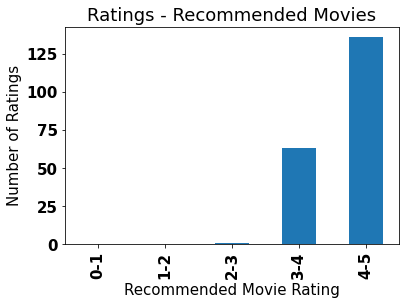

In [186]:
font = {'weight' : 'bold',
        'size'   : 15}
plt.rc('font', **font)

ax = ad.groupby(['ratingrange'])['ratingrange'].count().plot.bar()
ax.set_ylabel('Number of Ratings')
ax.set_xlabel('Recommended Movie Rating')
ax.set_title('Ratings - Recommended Movies')

# Checking for the long tail

In [ ]:
n = 20
top_n = 10
random.seed(42)
rand_user = random.sample(list_user, n)  
length = len(rand_user)
top_n
min_cnt = []

for u in range(length):
    # getting recommended movies
    recommendation =  recommendation_system(rand_user[u],movies_raitings,predicted_ratings,top_n)
    recommendation_rating = recommendation['cnt'].values

    # getting the min rating cnt of the movies recommended
    min_rating_cnt = recommendation_rating[:top_n]['cnt'].min()
    min_cnt.append(min_rating_cnt)

avg_min_cnt = np.mean(min_cnt)

In [189]:
n = 20
top_n = 10
random.seed(42)
rand_user = random.sample(list_user, n)  
length = len(rand_user)
top_n
min_cnt = []

for u in range(length):
    # getting recommended movies
    recommendation =  recommendation_system(rand_user[u],movies_raitings,predicted_ratings,top_n)
    recommendation_rating = recommendation['cnt'].values
    min_rating_cnt = recommendation_rating.min()
    min_cnt.append(min_rating_cnt)
avg_min_cnt = np.mean(min_cnt)

In [190]:
print(f"Average of the minimum count of ratings for {n} user's top {top_n} recommendations (long tail): {np.round(avg_min_cnt,2)}")

Average of the minimum count of ratings for 20 user's top 10 recommendations (long tail): 1401.0


In [209]:
users_ratings[users_ratings.userId == 17218].rating.sum()/260

3.1153846153846154

In [205]:
predicted_ratings[predicted_ratings.uid==17218].r_ui.unique()

array([3.54275843])

In [225]:
predicted_ratings.r_ui

0           3.542758
1           3.542758
2           3.542758
3           3.542758
4           3.542758
              ...   
17078478    3.542758
17078479    3.542758
17078480    3.542758
17078481    3.542758
17078482    3.542758
Name: r_ui, Length: 17078483, dtype: float64